In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
pip install transformers

     |████████████████████████████████| 368kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 59.9MB/s 
     |████████████████████████████████| 645kB 53.1MB/s 
     |████████████████████████████████| 860kB 50.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=6ff29ceff2215c721dcbe9b1584217b4160ef5eb4f53e82e3ae3346a1b54029f
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import XLMTokenizer, XLMConfig
from transformers import AdamW, XLMForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
# Upload the train file from your local drive
# from google.colab import files
# uploaded = files.upload()

Saving data.csv to data.csv


In [5]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive/
/gdrive


In [0]:
# data = pd.read_csv('data.csv')
data = pd.read_csv('My Drive/Colab Notebooks/data.csv')

In [7]:
df = data[['Rating','Review_text']].rename(columns={'Rating': 'label', 'Review_text': 'sentence'})
df.label = df.label.astype(int)
df.label = df.label - 1
df = df.dropna()

df = df.head(1000)
df.sample(10)

,label,sentence
968,4,Best
613,4,Using it from more than 2 years. Sound quality...
816,4,The feature is good and the pricing is better
437,4,Super
29,4,Satisfied with this purchase. Must buy
892,0,Hundred percent waste of money
483,0,Very very worst product..
251,3,Amazing display and avarage camera performance...
901,4,the product doesn't need much words as it is v...
568,3,Product is good but only one thing is not give...


## Hyperparameters values as below
1. MAX_LEN = 128
2. learning_rate = 2e-5
3. batch_size = 32
4. epochs = 2

##### Select a batch size for training. For fine-tuning on a specific task, recommend batch size is 16 or 32
##### Number of training epochs (recommend between 2 and 4)

In [0]:
MAX_LEN = 128
learning_rate = 2e-5
batch_size = 32
epochs = 2

In [9]:
# Create sentence and label lists
sentences_actual = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences_actual = ["[CLS] " + sentences_actual + " [SEP]" for sentences_actual in sentences_actual]
labels_actual = df.label.values

tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-ende-1024', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences_actual]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

index = []
for i,x in enumerate(tokenized_texts):
    if len(x)<MAX_LEN:
        index.append(i)
sentences = []
labels=[]
for i in index:
   sentences.append(sentences_actual[i]) 
   labels.append(labels_actual[i])
print('total sentences are:',len(sentences))

tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-ende-1024', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = XLMForSequenceClassification.from_pretrained("xlm-mlm-ende-1024", num_labels=5)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=learning_rate,
                     )


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

100%|██████████| 1003294/1003294 [00:01<00:00, 932520.31B/s]


Tokenize the first sentence:
['[</w>', 'cl', 's</w>', ']</w>', 'i</w>', 'liked</w>', 'it</w>', '[</w>', 'se', 'p</w>', ']</w>']
total sentences are: 959
Tokenize the first sentence:
['[</w>', 'cl', 's</w>', ']</w>', 'i</w>', 'liked</w>', 'it</w>', '[</w>', 'se', 'p</w>', ']</w>']


100%|██████████| 834712214/834712214 [01:08<00:00, 12146588.56B/s]


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 1.2918339967727661


Epoch:  50%|█████     | 1/2 [00:09<00:09,  9.51s/it]

Validation Accuracy: 0.6041666666666666
Train loss: 1.2286831140518188


Epoch: 100%|██████████| 2/2 [00:18<00:00,  9.45s/it]

Validation Accuracy: 0.59375


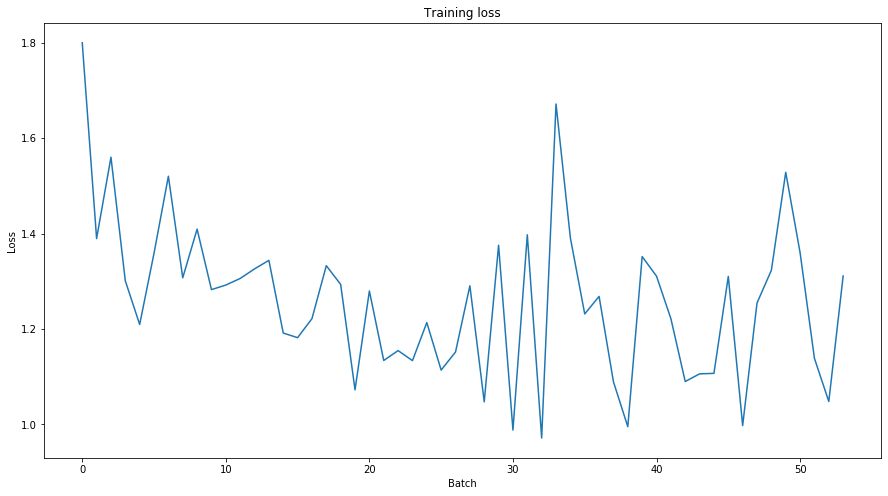

In [10]:
# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids,  attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0])    
    # # Backward pass
    loss[0].backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss[0]
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids,  attention_mask=b_input_mask)[0]
     
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Hyperparameters values as below
1. MAX_LEN = 128
2. learning_rate = 2e-5
3. batch_size = 16
4. epochs = 3

In [0]:
MAX_LEN = 128
learning_rate = 2e-5
batch_size = 16
epochs = 3


In [12]:
# Create sentence and label lists
sentences_actual = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences_actual = ["[CLS] " + sentences_actual + " [SEP]" for sentences_actual in sentences_actual]
labels_actual = df.label.values

tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-ende-1024', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences_actual]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

index = []
for i,x in enumerate(tokenized_texts):
    if len(x)<MAX_LEN:
        index.append(i)
sentences = []
labels=[]
for i in index:
   sentences.append(sentences_actual[i]) 
   labels.append(labels_actual[i])
print('total sentences are:',len(sentences))

tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-ende-1024', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = XLMForSequenceClassification.from_pretrained("xlm-mlm-ende-1024", num_labels=5)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=learning_rate,
                     )


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Tokenize the first sentence:
['[</w>', 'cl', 's</w>', ']</w>', 'i</w>', 'liked</w>', 'it</w>', '[</w>', 'se', 'p</w>', ']</w>']
total sentences are: 959
Tokenize the first sentence:
['[</w>', 'cl', 's</w>', ']</w>', 'i</w>', 'liked</w>', 'it</w>', '[</w>', 'se', 'p</w>', ']</w>']


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 1.288687825202942


Epoch:  33%|███▎      | 1/3 [00:11<00:22, 11.02s/it]

Validation Accuracy: 0.6041666666666666
Train loss: 1.2590900659561157


Epoch:  67%|██████▋   | 2/3 [00:22<00:11, 11.02s/it]

Validation Accuracy: 0.6041666666666666
Train loss: 1.237821340560913


Epoch: 100%|██████████| 3/3 [00:33<00:00, 11.02s/it]

Validation Accuracy: 0.6041666666666666


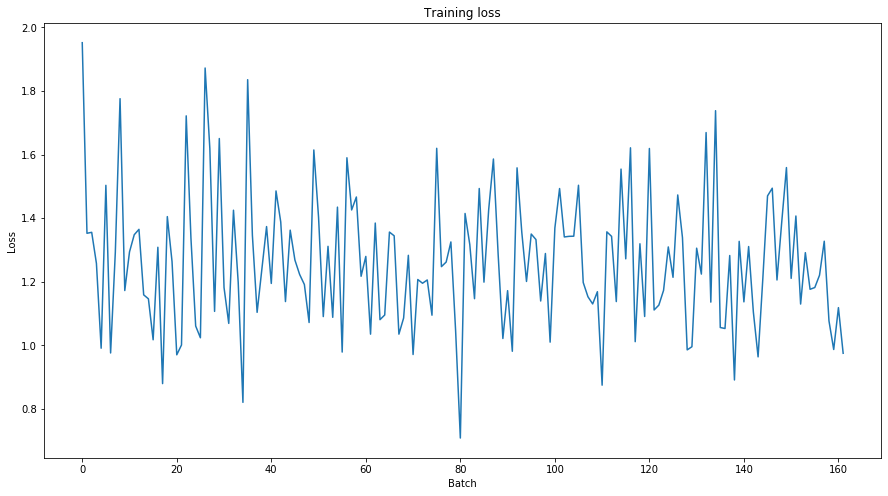

In [13]:
# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids,  attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0])    
    # # Backward pass
    loss[0].backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss[0]
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, attention_mask=b_input_mask)[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Hyperparameters values as below
1. MAX_LEN = 128
2. learning_rate = 2e-5
3. batch_size = 16
4. epochs = 10

In [0]:
MAX_LEN = 128
learning_rate = 2e-5
batch_size = 16
epochs = 10


In [15]:
# Create sentence and label lists
sentences_actual = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences_actual = ["[CLS] " + sentences_actual + " [SEP]" for sentences_actual in sentences_actual]
labels_actual = df.label.values

tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-ende-1024', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences_actual]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

index = []
for i,x in enumerate(tokenized_texts):
    if len(x)<MAX_LEN:
        index.append(i)
sentences = []
labels=[]
for i in index:
   sentences.append(sentences_actual[i]) 
   labels.append(labels_actual[i])
print('total sentences are:',len(sentences))

tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-ende-1024', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = XLMForSequenceClassification.from_pretrained("xlm-mlm-ende-1024", num_labels=5)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=learning_rate,
                     )


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Tokenize the first sentence:
['[</w>', 'cl', 's</w>', ']</w>', 'i</w>', 'liked</w>', 'it</w>', '[</w>', 'se', 'p</w>', ']</w>']
total sentences are: 959
Tokenize the first sentence:
['[</w>', 'cl', 's</w>', ']</w>', 'i</w>', 'liked</w>', 'it</w>', '[</w>', 'se', 'p</w>', ']</w>']


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.2860612869262695


Epoch:  10%|█         | 1/10 [00:11<01:39, 11.04s/it]

Validation Accuracy: 0.6041666666666666
Train loss: 1.2426565885543823


Epoch:  20%|██        | 2/10 [00:22<01:28, 11.03s/it]

Validation Accuracy: 0.5729166666666666
Train loss: 1.2146857976913452


Epoch:  30%|███       | 3/10 [00:33<01:17, 11.02s/it]

Validation Accuracy: 0.6041666666666666
Train loss: 1.206616759300232


Epoch:  40%|████      | 4/10 [00:44<01:06, 11.02s/it]

Validation Accuracy: 0.6041666666666666
Train loss: 1.1380406618118286


Epoch:  50%|█████     | 5/10 [00:55<00:55, 11.02s/it]

Validation Accuracy: 0.6041666666666666
Train loss: 1.0377514362335205


Epoch:  60%|██████    | 6/10 [01:06<00:44, 11.02s/it]

Validation Accuracy: 0.6458333333333334
Train loss: 1.0522555112838745


Epoch:  70%|███████   | 7/10 [01:17<00:33, 11.01s/it]

Validation Accuracy: 0.5729166666666666
Train loss: 0.908679187297821


Epoch:  80%|████████  | 8/10 [01:28<00:22, 11.01s/it]

Validation Accuracy: 0.625
Train loss: 0.8112658858299255


Epoch:  90%|█████████ | 9/10 [01:39<00:11, 11.01s/it]

Validation Accuracy: 0.6145833333333334
Train loss: 0.762062668800354


Epoch: 100%|██████████| 10/10 [01:50<00:00, 11.01s/it]

Validation Accuracy: 0.6145833333333334


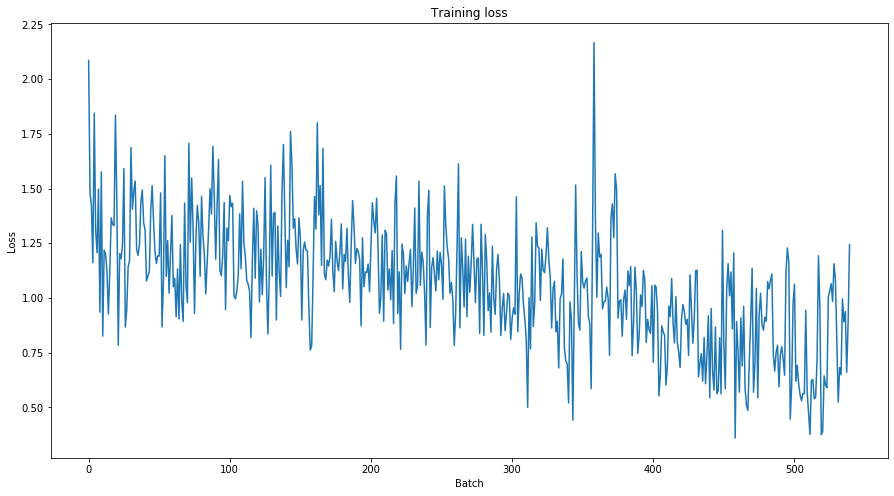

In [16]:
# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids,  attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0])    
    # # Backward pass
    loss[0].backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss[0]
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, attention_mask=b_input_mask)[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Hyperparameters values as below
1. MAX_LEN = 512
2. learning_rate = 2e-5
3. batch_size = 16
4. epochs = 10

In [0]:
MAX_LEN = 512
learning_rate = 2e-5
batch_size = 16
epochs = 10

In [20]:
# Create sentence and label lists
sentences_actual = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences_actual = ["[CLS] " + sentences_actual + " [SEP]" for sentences_actual in sentences_actual]
labels_actual = df.label.values

tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-ende-1024', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences_actual]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

index = []
for i,x in enumerate(tokenized_texts):
    if len(x)<MAX_LEN:
        index.append(i)
sentences = []
labels=[]
for i in index:
   sentences.append(sentences_actual[i]) 
   labels.append(labels_actual[i])
print('total sentences are:',len(sentences))

tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-ende-1024', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = XLMForSequenceClassification.from_pretrained("xlm-mlm-ende-1024", num_labels=5)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=learning_rate,
                     )


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Tokenize the first sentence:
['[</w>', 'cl', 's</w>', ']</w>', 'i</w>', 'liked</w>', 'it</w>', '[</w>', 'se', 'p</w>', ']</w>']
total sentences are: 999
Tokenize the first sentence:
['[</w>', 'cl', 's</w>', ']</w>', 'i</w>', 'liked</w>', 'it</w>', '[</w>', 'se', 'p</w>', ']</w>']


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.2782806158065796


Epoch:  10%|█         | 1/10 [00:39<05:55, 39.53s/it]

Validation Accuracy: 0.5535714285714286
Train loss: 1.2122344970703125


Epoch:  20%|██        | 2/10 [01:18<05:16, 39.51s/it]

Validation Accuracy: 0.5
Train loss: 1.1859118938446045


Epoch:  30%|███       | 3/10 [01:58<04:36, 39.50s/it]

Validation Accuracy: 0.5714285714285714
Train loss: 1.1727412939071655


Epoch:  40%|████      | 4/10 [02:37<03:56, 39.49s/it]

Validation Accuracy: 0.5714285714285714
Train loss: 1.1091786623001099


Epoch:  50%|█████     | 5/10 [03:17<03:17, 39.49s/it]

Validation Accuracy: 0.5892857142857143
Train loss: 1.0108247995376587


Epoch:  60%|██████    | 6/10 [03:56<02:37, 39.49s/it]

Validation Accuracy: 0.625
Train loss: 0.9727487564086914


Epoch:  70%|███████   | 7/10 [04:36<01:58, 39.49s/it]

Validation Accuracy: 0.6696428571428571
Train loss: 0.8862159252166748


Epoch:  80%|████████  | 8/10 [05:15<01:18, 39.49s/it]

Validation Accuracy: 0.6071428571428571
Train loss: 0.8091033101081848


Epoch:  90%|█████████ | 9/10 [05:55<00:39, 39.49s/it]

Validation Accuracy: 0.6428571428571429
Train loss: 0.7687735557556152


Epoch: 100%|██████████| 10/10 [06:34<00:00, 39.48s/it]

Validation Accuracy: 0.6517857142857143


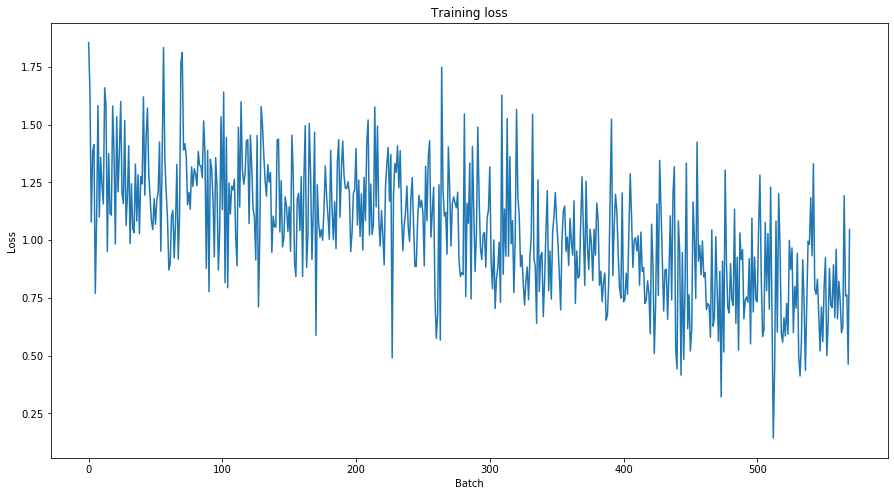

In [21]:
# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids,  attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0])    
    # # Backward pass
    loss[0].backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss[0]
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, attention_mask=b_input_mask)[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()